In [10]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [11]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [12]:
# ylabel_name = 'marions_ylabels_esd_removed'
ylabel_name = 'marions_ylabels'
data_features = pd.read_csv("data/optimal_features.csv")
print(data_features.columns)
data_features['popcorn'] = data_features['popcorn'].astype('boolean')
data_features['clump'] = data_features['clump'].astype('boolean')
clustering_features = plotting.extract_numerical_features(data_features)

Index(['largest_force_drop_size', 'force_mean', 'curve_first_quarter_slope',
       'rsquared', 'depth_max', 'filenames', 'marions_ylabels', 'distances',
       'popcorn', 'clump', 'flake', 'plates', 'marions_ylabels_nums'],
      dtype='object')


In [13]:
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
cluster_num_to_ylabel = {v: k for k, v in ylabel_to_cluster_num.items()}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

In [14]:
def loss(pseudo_labels:pd.Series, actual_labels:pd.Series):
    pseudo_actual_intersection = pseudo_labels.loc[actual_labels.index]
    diff_mask = pseudo_actual_intersection != actual_labels
    diff_labels = pseudo_actual_intersection[diff_mask]
    return diff_labels.index
    
def correct_pseudo_ylabels_to_actual(pseudo_labels:pd.Series, actual_labels:pd.Series, changed_ylabel_idxs) -> pd.Series:
    corrected_pseudo_labels = pseudo_labels.copy()
    corrected_pseudo_labels.loc[changed_ylabel_idxs] = actual_labels
    return corrected_pseudo_labels

# Split Based on Popcorn

cluster_key: 0
	 1
	 19
	 29
	 30
	 32
	 33
	 37
	 60
	 61
	 62
	 63
	 64
	 73
	 74
	 79
	 80
	 82
	 83
	 88
	 92
	 101
	 102
	 104
	 106
	 109
cluster_key: 1
	 2
	 3
	 4
	 26
	 44
	 48
	 50
	 91
	 94


/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



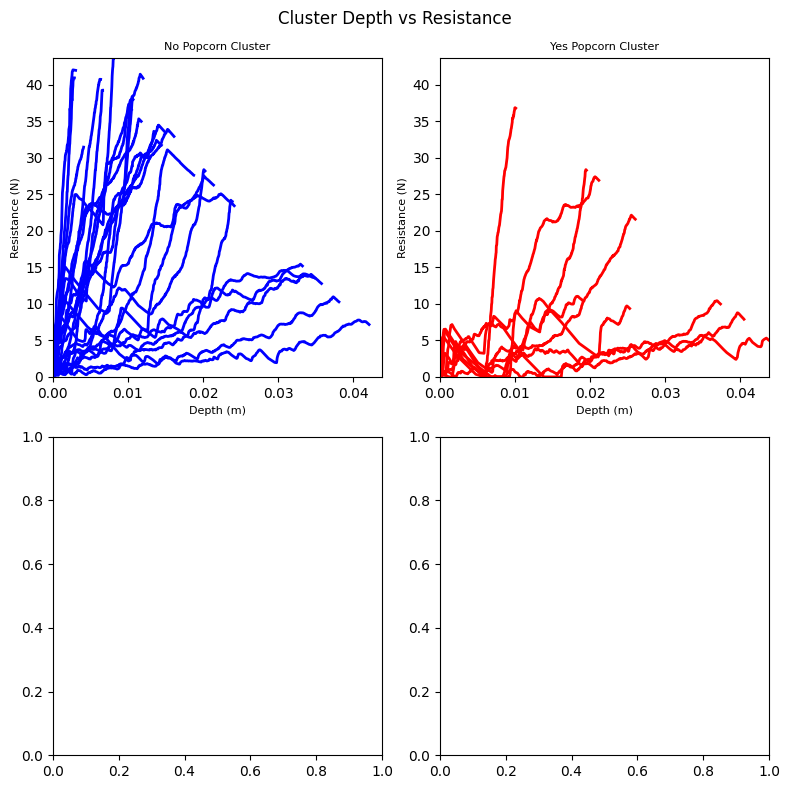

In [15]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "popcorn"
data_with_popcorn_label = data_features[data_features['popcorn'].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label['popcorn'].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')
# print(data_with_popcorn_label[data_with_popcorn_label['popcorn']][['filenames', 'popcorn']])
# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            cluster_category_names=["No Popcorn", "Yes Popcorn"], 
                            bold_idxs=popcorn_ylabels.index,
                            prediction_proba=proba)
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, centroids=centroids)

# # plotting labeled with predictions
# plotting.plot_cluster_subplots(
#                             corrected_predctions,
#                             curve_data,
#                             cluster_category_names=["No Popcorn", "Yes Popcorn"],
#                             bold_idxs=popcorn_ylabels.index,
#                             prediction_proba=proba)
# plotting.plot_pca(clustering_features, corrected_predctions, 3, "", ylabel_name=ylabel_name, centroids=centroids)


# Split based on clump

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



cluster_key: 0
	 2
	 3
	 4
	 13
	 19
	 26
	 29
	 44
	 45
	 48
	 62
	 81
	 83
	 94
	 102
	 104
	 106
	 109
cluster_key: 1
	 1
	 30
	 63
	 64
	 73
	 101


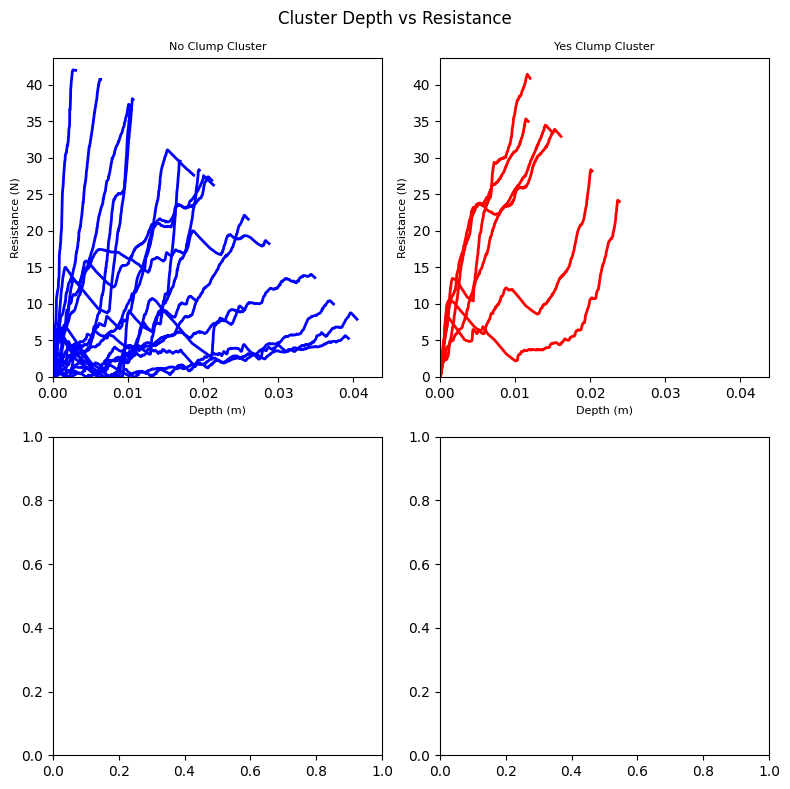

In [16]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "clump"
data_with_popcorn_label = data_features[data_features[ylabel_name].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label[ylabel_name].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')

# print(data_with_popcorn_label[data_with_popcorn_label[ylabel_name]].index)
# print(data_with_popcorn_label[~data_with_popcorn_label[ylabel_name]].index)

# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            cluster_category_names=[f"No {ylabel_name}", f"Yes {ylabel_name}"], 
                            bold_idxs=popcorn_ylabels.index,
                            prediction_proba=proba,)
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, centroids=centroids)


# Flaky

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



cluster_key: 0
	 1
	 2
	 3
	 4
	 13
	 19
	 26
	 44
	 45
	 48
	 63
	 64
	 73
	 81
	 101
	 106
	 109
cluster_key: 1
	 29
	 30
	 62
	 83
	 94
	 102
	 104


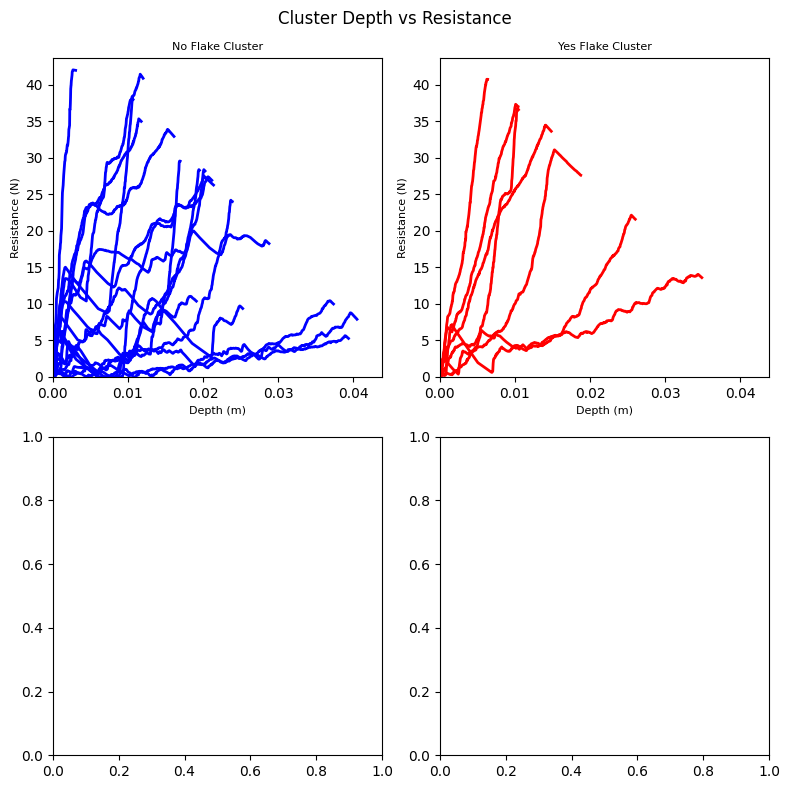

In [17]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "flake"
data_with_popcorn_label = data_features[data_features[ylabel_name].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label[ylabel_name].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')

# print(data_with_popcorn_label[data_with_popcorn_label[ylabel_name]].index)
# print(data_with_popcorn_label[~data_with_popcorn_label[ylabel_name]].index)

# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            cluster_category_names=[f"No {ylabel_name}", f"Yes {ylabel_name}"], 
                            bold_idxs=popcorn_ylabels.index,
                            prediction_proba=proba,)
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, centroids=centroids)


# Plates

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



[[0.89 0.11]
 [0.41 0.59]
 [0.18 0.82]
 [0.74 0.26]
 [0.45 0.55]
 [0.87 0.13]
 [0.85 0.15]
 [0.56 0.44]
 [0.83 0.17]
 [0.96 0.04]
 [0.74 0.26]
 [0.65 0.35]
 [0.7  0.3 ]
 [0.61 0.39]
 [0.74 0.26]
 [0.86 0.14]
 [0.78 0.22]
 [0.71 0.29]
 [0.91 0.09]
 [0.63 0.37]
 [0.92 0.08]
 [0.74 0.26]
 [0.73 0.27]
 [0.69 0.31]
 [0.85 0.15]
 [0.84 0.16]
 [0.5  0.5 ]
 [0.96 0.04]
 [0.92 0.08]
 [0.74 0.26]
 [0.85 0.15]
 [0.92 0.08]
 [0.57 0.43]
 [0.67 0.33]
 [0.85 0.15]
 [0.73 0.27]
 [0.92 0.08]
 [0.33 0.67]
 [0.7  0.3 ]
 [0.83 0.17]
 [0.87 0.13]
 [0.81 0.19]
 [0.89 0.11]
 [0.91 0.09]
 [0.18 0.82]
 [0.16 0.84]
 [0.94 0.06]
 [0.95 0.05]
 [0.23 0.77]
 [0.89 0.11]
 [0.63 0.37]
 [0.82 0.18]
 [0.92 0.08]
 [0.58 0.42]
 [0.84 0.16]
 [0.52 0.48]
 [0.56 0.44]
 [0.93 0.07]
 [0.85 0.15]
 [0.93 0.07]
 [0.86 0.14]
 [0.54 0.46]
 [0.92 0.08]
 [0.65 0.35]
 [0.83 0.17]
 [0.9  0.1 ]
 [0.85 0.15]
 [0.86 0.14]
 [0.28 0.72]
 [0.29 0.71]
 [0.86 0.14]
 [0.7  0.3 ]
 [0.73 0.27]
 [0.15 0.85]
 [0.94 0.06]
 [0.77 0.23]
 [0.9  0.1 ]

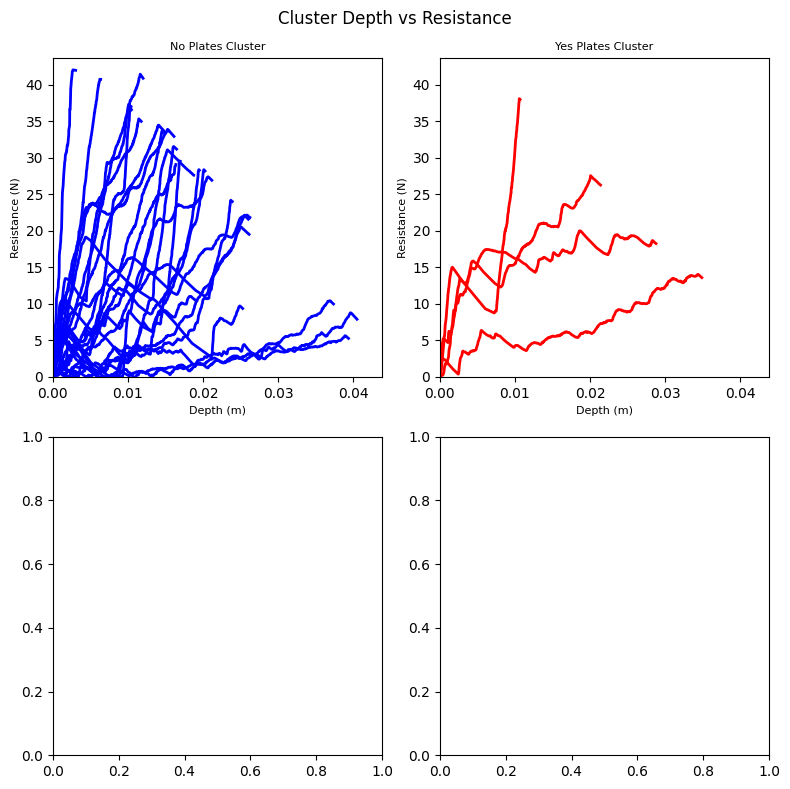

In [18]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "plates"
data_with_popcorn_label = data_features[data_features[ylabel_name].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label[ylabel_name].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)
print(proba)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')

# print(data_with_popcorn_label[data_with_popcorn_label[ylabel_name]].index)
# print(data_with_popcorn_label[~data_with_popcorn_label[ylabel_name]].index)

# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            cluster_category_names=[f"No {ylabel_name}", f"Yes {ylabel_name}"], 
                            bold_idxs=popcorn_ylabels.index,
                            prediction_proba=proba,)
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, centroids=centroids)
